In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
#!unzip -q ~/data/salt_keras/train.zip -d ~/data/salt_keras/train
#!unzip -q ~/data/salt_keras/test.zip -d ~/data/salt_keras/test


In [211]:
# Set some parameters
im_width = 64
im_height = 64
border = 5
#path_train = '/home/labis/data/salt_keras/train/'
path_train = '/home/labis/eclipse-workspace/Utilities/'
path_test = '/home/labis/eclipse-workspace/Utilities/'

In [212]:
from tqdm import tqdm


# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "images"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (im_width, im_height, 1), mode='constant', preserve_range=True)
        
        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/labels/' + id_, grayscale=True))
            mask = resize(mask, (im_width, im_height, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)
#print(X[0][:10][:10])
#plt.imshow(X[0].squeeze(), cmap='Greys_r');

100%|██████████| 4/4 [00:00<00:00, 256.97it/s]

Getting and resizing images ... 
Done!


In [213]:
print(X.shape)

(4, 64, 64, 1)


In [214]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2020)
print(X_train.shape)

(3, 64, 64, 1)


1


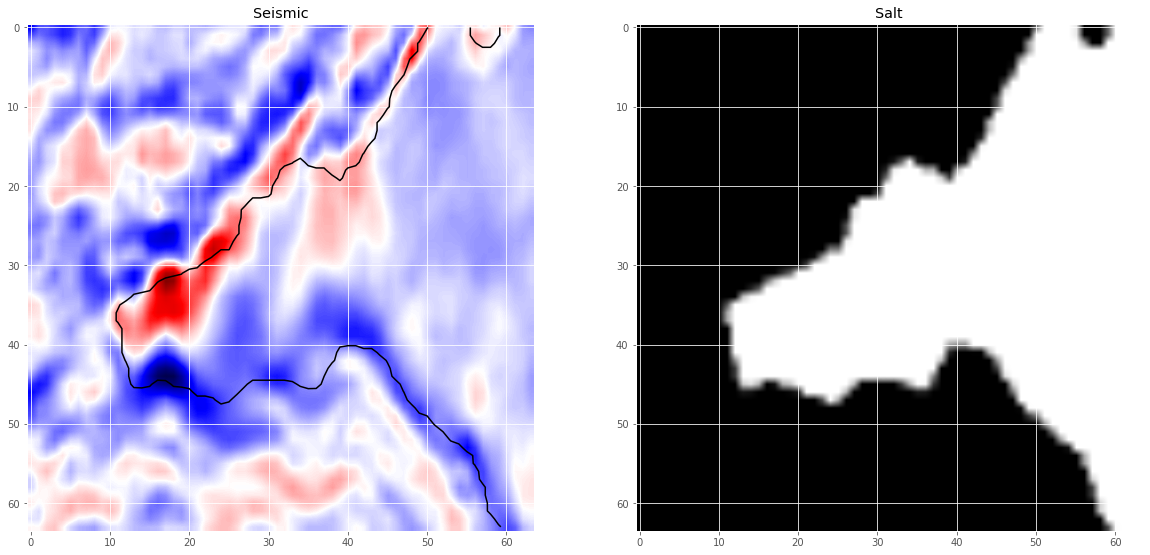

In [215]:
ix = random.randint(0,len(X_train)-1) ### -1 needed...
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].imshow(X_train[ix,...,0], cmap='seismic', interpolation = 'bilinear')

if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')


ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt')
print(ix)

In [306]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = False):
    
    x = Conv2D(filters = n_filters, kernel_size =(kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = n_filters, kernel_size =(kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [307]:
def get_unet(input_img,n_filters = 16, dropout = 0.5, batchnorm = False):
    #Encoder part
    c1 = conv2d_block(input_img,n_filters=n_filters,kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D(pool_size=(2, 2),strides =(2,2), padding='valid') (c1)
    #p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)


    p2 = MaxPooling2D(pool_size=(2, 2),strides =(2,2), padding='valid')  (c2)
    #p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D(pool_size=(2, 2),strides =(2,2), padding='valid')  (c3)
    #p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2),strides =(2,2), padding='valid') (c4)
    #p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    #Decoder part
    
    u6 = Conv2DTranspose(n_filters*8, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    #u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    #u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    #u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    #u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
    

In [308]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0, batchnorm=False)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()



Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 64, 64, 16)   160         img[0][0]                        
__________________________________________________________________________________________________
activation_105 (Activation)     (None, 64, 64, 16)   0           conv2d_96[0][0]                  
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 64, 64, 16)   2320        activation_105[0][0]             
____________________________________________________________________________________________

In [309]:
results = model.fit(X_train, y_train, batch_size=2, epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 394ms/step - loss: 0.6870 - accuracy: 0.5344
Epoch 2/100
3/3 [==============================] - 0s 54ms/step - loss: 0.6846 - accuracy: 0.5408
Epoch 3/100
3/3 [==============================] - 0s 59ms/step - loss: 0.6792 - accuracy: 0.5624
Epoch 4/100
3/3 [==============================] - 0s 60ms/step - loss: 0.6873 - accuracy: 0.5798
Epoch 5/100
3/3 [==============================] - 0s 57ms/step - loss: 0.6865 - accuracy: 0.5854
Epoch 6/100
3/3 [==============================] - 0s 59ms/step - loss: 0.6824 - accuracy: 0.6136
Epoch 7/100
3/3 [==============================] - 0s 58ms/step - loss: 0.6808 - accuracy: 0.5870
Epoch 8/100
3/3 [==============================] - 0s 59ms/step - loss: 0.6754 - accuracy: 0.5798
Epoch 9/100
3/3 [==============================] - 0s 58ms/step - loss: 0.6708 - accuracy: 0.5905
Epoch 10/100
3/3 [==============================] - 0s 57ms/step - loss: 0.6631 - accuracy: 0.6335
Epoch 11/100
3/3 [

3/3 [==============================] - 0s 73ms/step - loss: 0.0157 - accuracy: 0.9754
Epoch 84/100
3/3 [==============================] - 0s 80ms/step - loss: 0.0190 - accuracy: 0.9746
Epoch 85/100
3/3 [==============================] - 0s 73ms/step - loss: 0.0171 - accuracy: 0.9754
Epoch 86/100
3/3 [==============================] - 0s 59ms/step - loss: 0.0200 - accuracy: 0.9744
Epoch 87/100
3/3 [==============================] - 0s 60ms/step - loss: 0.0390 - accuracy: 0.9707
Epoch 88/100
3/3 [==============================] - 0s 63ms/step - loss: 0.0200 - accuracy: 0.9742
Epoch 89/100
3/3 [==============================] - 0s 58ms/step - loss: 0.0272 - accuracy: 0.9719
Epoch 90/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0187 - accuracy: 0.9749
Epoch 91/100
3/3 [==============================] - 0s 58ms/step - loss: 0.0240 - accuracy: 0.9734
Epoch 92/100
3/3 [==============================] - 0s 62ms/step - loss: 0.0184 - accuracy: 0.9753
Epoch 93/100
3/3 [=====

KeyError: 'val_loss'

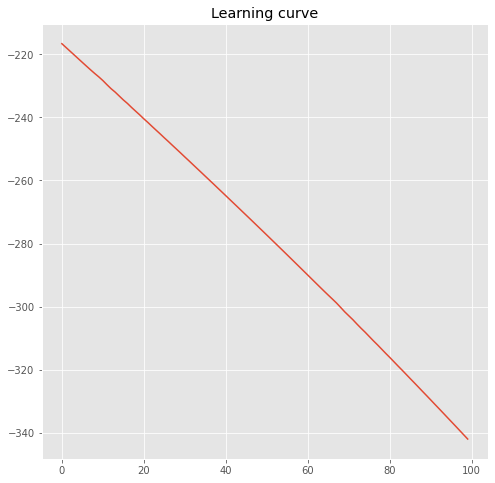

In [102]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

In [52]:
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 100ms/step


[3.239691734313965, 0.717529296875]

In [310]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 16ms/step


In [311]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary')

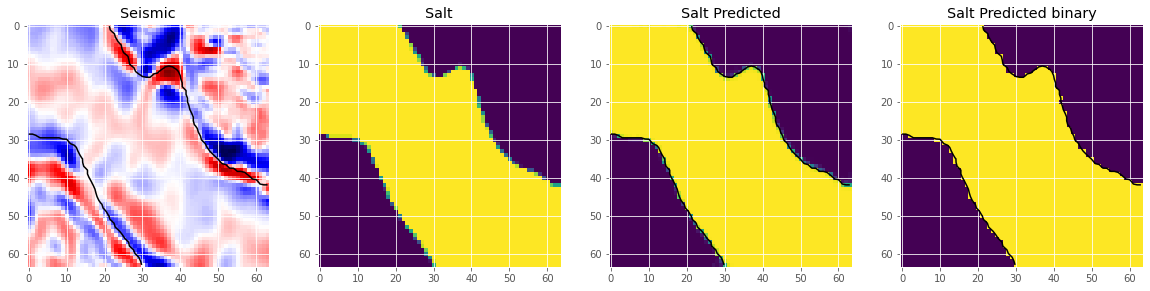

In [312]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=0)

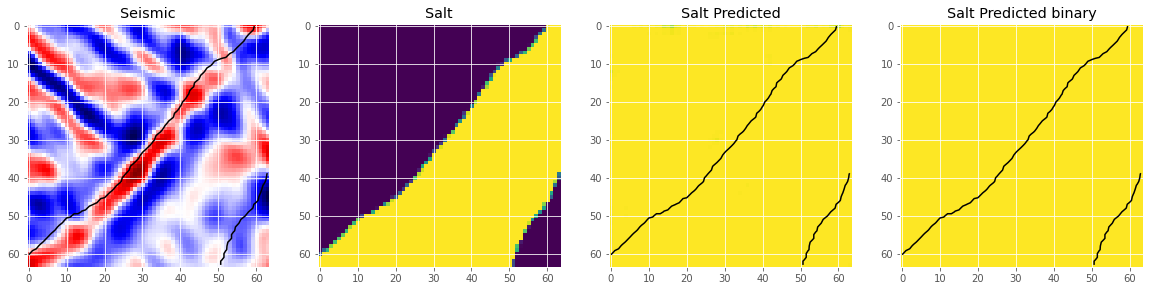

In [18]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=0)

In [314]:
model.save_weights("/home/labis/eclipse-workspace/Utilities/Keras_Weights.h5")

In [131]:
model.load_weights("/home/labis/eclipse-workspace/Utilities/Keras_Weights.h5")

In [273]:
k = np.array([
    [1, 5],
    [2.8, 1]
])
test = np.array([
    [4, 3, 1, 0.5],
    [2, 1.5, 4.4, 1],
    [1.2, 2, 4.1, 1],
    [3, 1, 0.8, 2]])
test=test.reshape(1,4,4);
k=k.reshape(1,1,2,2);
b = np.zeros(1)
params=[k,b]

In [300]:
def conv(image, params, s = 1, pad = 1 ): # s = 1 (conv stride)
    #f1 shape : (num_filters,input channels, f_h, f_w)
    #image shape: (channels, height, width)
    [f, b] = params
    if(pad >= 1):
        tmp = np.zeros((image.shape[0],image.shape[1]+2*pad ,image.shape[2]+2*pad))
        tmp[:,pad:-pad,pad:-pad] = image
        image = tmp    
        
    f_num = f.shape[0]
    f_depth = f.shape[1] #f1 = 1 , f2 = 8
    f_size = f.shape[2] 
        

    h_range = int((image.shape[1] - f_size) / s) + 1     # (W - F + 2P) / S  
    w_range = int((image.shape[2] - f_size) / s) + 1     # (W - F + 2P) / S  
    np_o = np.zeros((f_num, h_range, w_range))
    for z in range(f_num): # Number of filters
        for _h in range(h_range):      
            for _w in range(w_range):
                np_o[z, _h, _w] = np.sum(np.multiply(image[:, _h*s : _h*s + f_size, _w*s : _w*s + f_size] , f[z, :, :, :])) + b[z]
    
    return np_o
def convTransp(image, params, s = 1, pad = 1):
    #s is always 1, upsample kernel = 2
    #zero insertions between pixels s_downsampled -1 = 2-1 = 1
    #required padding in order to double my dimensions with the given data:
    #(i-1)*2 + k -2p = output size, where our padding is k - p -1 = 2-0-1=1(we assume p=0)
    [f, b]=params
    f = np.rot90(f, 2, (2,3))
    params = [f, b]
    input_s = image.shape[1]
    target_dim = input_s*2 #final dim, after conv
    required_pad = 1 #always for filter 2x2 ,stride 1, zero insertion 1 and main target to double dim
    #make our new custom input
    size = input_s*2 +1
    new_in = np.zeros((image.shape[0], size, size))
    
    ### OR just: np.pad(image[:,:,:],2,'constant') # Important, we must loop with respect to the 1st dim
    for i in range(1, target_dim, 2):
        for j in range(1, target_dim, 2):
                new_in[:, i, j] = image[:, i//2, j//2]
    
    #now we do a normal convolution(pad = 0)
    res = conv(new_in, params, 1, 0) #thats the final result with target_dim
    return res, new_in # we will need new_in so we wont calc it again for the backprop
def maxpool(image, f=2 , s=2):
    
    h_range = int((image.shape[1] - f) / s) + 1     # (W - F + 2P) / S  
    w_range = int((image.shape[2] - f) / s) + 1     # (W - F + 2P) / S 
    out = np.zeros((image.shape[0], h_range, w_range))
    
    for z in range(image.shape[0]): # Number of channels
        for _h in range(h_range):      
            for _w in range(w_range):
                out[z, _h, _w] = np.max(image[z, _h*s : _h*s + f, _w*s : _w*s + f])
    return out

In [301]:

res1,_=convTransp(test,params,1,1)
print(res1)



[[[20.  15.   5.   2.5]
  [10.   7.5 22.   5. ]
  [ 6.  10.  20.5  5. ]
  [15.   5.   4.  10. ]]]


In [277]:
# import tensorflow as tf

ke = tf.constant([
    [1, 5],
    [2.8, 1]
], dtype=tf.float32, name='k')
i = tf.constant([
    [4, 3, 1, 0.5],
    [2, 1.5, 4.4, 1],
    [1.2, 2, 4.1, 1],
    [3, 1, 0.8, 2]], dtype=tf.float32, name='i')
kernel = tf.reshape(ke, [2, 2, 1, 1], name='kernel')
image  = tf.reshape(i, [1, 4, 4, 1], name='image')
#res = tf.squeeze(tf.nn.conv2d_transpose(image, kernel,8,3, "VALID"))
# VALID means no padding
#print(res)

In [278]:
def conv2d_transpose_strided(x, W, b, output_shape=None):
    # print x.get_shape()
    # print W.get_shape()
    if output_shape is None:
        output_shape = x.get_shape().as_list()
        output_shape[1] *= 2 
        output_shape[2] *= 2
        output_shape[3] = W.get_shape().as_list()[2]
    # print output_shape
    conv = tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, 2, 2, 1], padding="SAME")
    return tf.nn.bias_add(conv, b)

In [303]:
import sys
bias = tf.constant([
    0], dtype=tf.float32, name='bias')
res = tf.squeeze(conv2d_transpose_strided(image,kernel,bias))
#x=tf.compat.v1.nn.relu(res)
print(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(tf.reshape(res, [1, 8, 8, 1], name='image')))

tf.Tensor(
[[[[20. ]
   [15. ]
   [ 5. ]
   [ 2.5]]

  [[10. ]
   [ 7.5]
   [22. ]
   [ 5. ]]

  [[ 6. ]
   [10. ]
   [20.5]
   [ 5. ]]

  [[15. ]
   [ 5. ]
   [ 4. ]
   [10. ]]]], shape=(1, 4, 4, 1), dtype=float32)
